## Basical settings

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder
import multiprocessing
import time
import torch

/home/yl127/anaconda3/envs/astrodet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi
print(torch.__version__)
print(torch.cuda.is_available())

Fri Feb 10 14:37:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:04:00.0 Off |                  Off |
| N/A   36C    P0    37W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Global variables

In [3]:
wavelengths     = np.arange(400, 800)*u.nm
FWHM            = 0.5
lambda_Na       = 589.0*u.nm
lambda_Mg       = 518.3*u.nm
width           = 1000
height          = 1500

dir='./dataset/'

## Generate dataset

Define the function to generate the image. 

In [3]:
def add_background(image_3d):
    '''
    '''
    # TODO: mutate the background
    for i in range(400):
        image_3d[:,:,i] += int(30-0.06*i)
    return image_3d

def add_stars(image_3d, coord_stars, amp_stars, T_stars): 
    '''
    '''
    # psf
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    # draw N stars with radius FWHM/2
    for [x, y], amp_star, T_star in zip(coord_stars, amp_stars, T_stars): 
        # spectrum
        BB = models.BlackBody(temperature=T_star)
        # add star to the image
        radius = int(5*FWHM)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*BB(wavelengths).value*amp_star
        star = star.astype('uint16')
        image_3d[x-radius:x+radius+1,y-radius:y+radius+1,:] += star
    return image_3d

def add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, dir_meteor, length_meteor): 
    '''
    '''
    # spectrum - continuous spectrum
    BB = models.BlackBody(temperature=T_meteor)
    meteor_x = BB(wavelengths).value*amp_meteor
    # spectrum - emission line
    amp_Na = amp_meteor*2e-6
    amp_Mg = amp_meteor*1e-6
    emission_Na = functional_models.Gaussian1D(mean=lambda_Na.value, stddev=FWHM)
    emission_Mg = functional_models.Gaussian1D(mean=lambda_Mg.value, stddev=FWHM)
    meteor_x += emission_Na(wavelengths.value)*amp_Na
    meteor_x += emission_Mg(wavelengths.value)*amp_Mg
    # trajectory
    meteor_y = np.arange(length_meteor)
    amplitude = 1e3
    # TODO: use true trajectory
    meteor_y = (meteor_y*10/length_meteor)**(0.1) - meteor_y/length_meteor
    meteor_y = meteor_y*amplitude
    meteor = np.outer(meteor_y, meteor_x)
    # draw meteor
    dx = np.cos(dir_meteor)
    dy = np.sin(dir_meteor)
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    for i in range(length_meteor): 
        radius = int(5*FWHM)
        x_plot = int(coord_meteor[0] + dx*i)
        y_plot = int(coord_meteor[1] + dy*i)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*meteor[i, :]
        star = star.astype('uint16')
        image_3d[x_plot-radius:x_plot+radius+1,y_plot-radius:y_plot+radius+1,:] += star
    # plt.imshow(meteor)
    # plt.colorbar()
    # plt.show()


    # TODO: return the bounding box
    return image_3d

def add_landscape(image_3d): 
    '''
    TODO
    '''
    return image_3d

def capture(image_3d, direction, length): 
    '''
    '''
    dx = np.cos(direction)
    dy = np.sin(direction)
    for i in range(400): 
        # print(i, int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=0, shift=int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=1, shift=int(dy*length*i/400))
    image_rgb = np.zeros([width, height, 3], dtype=np.uint16)
    # RGB filter
    # TODO: adjust the RGB curve of camera
    # TODO: adjust the true slit distortion
    gaussian_r = functional_models.Gaussian1D(mean=600, stddev=30)
    gaussian_g = functional_models.Gaussian1D(mean=540, stddev=30)
    gaussian_b = functional_models.Gaussian1D(mean=480, stddev=30)
    filter_r = gaussian_r(wavelengths.value)
    filter_g = gaussian_g(wavelengths.value)
    filter_b = gaussian_b(wavelengths.value)
    filter_r[200:400] = 1-np.arange(200)**2/200**2
    # generate RGB components
    image_rgb[:, :, 0] = np.average(image_3d*filter_r, axis=2)
    image_rgb[:, :, 1] = np.average(image_3d*filter_g, axis=2)
    image_rgb[:, :, 2] = np.average(image_3d*filter_b, axis=2)
    image_rgb = image_rgb.astype('uint16')
    return image_rgb

def augmentation(image_rgb): 
    '''
    Add the lens effect such as disortion and gaussian noise
    TODO: use `imgaug`
    '''
    return image_rgb


def generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                    angle_meteor, length_meteor, angle_slit, length_slit): 
    '''
    function to generate the image. 
    Args: 
        The position of all the stars, the meteor, etc.: 
        coords_stars    [N, 2]      the coordinates of stars plotted in the diagram. Will also give the number of stars
        TODO...
        angle_slit      [0, 2pi)
        angle_meteor    [0, 2pi)
        length_meteor   int         how long the meteor is 
        length_slit     int         how long the track of spectrum is
    Return: 
        one RGB image
    '''
    image_3d = np.zeros([width, height, 400], dtype=np.uint16)           # 0-65536, valid in 0-256 TODO: change to float16? 
    image_3d = add_background(image_3d)
    image_3d = add_stars(image_3d, coord_stars, amp_stars, T_stars)
    image_3d = add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, angle_meteor, length_meteor)
    image_rgb = capture(image_3d, angle_slit, length_slit)
    image_rgb = augmentation(image_rgb)
    # clip the image
    image_rgb = np.clip(image_rgb, 0, 255)# including 0 and 255
    # image_rgb = image_rgb.astype('uint8')
    return image_rgb #image_3d[:,:,0]
    



In [9]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    # TODO: if exception
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    anno_id_start = max([i['id'] for i in labels['annotations']]) + 1
    anno_id = anno_id_start
    image_id_start = max([i['id'] for i in labels['images']]) + 1
    # Loop to generate images
    for image_id in range(image_id_start, image_id_start + num_images): 
        filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
        print('generating image: %s...'%filename)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        length_meteor   = int(np.random.rand()*500)                      # pixel
        x_meteor        = int(np.random.rand()*(width-2*length_meteor)+length_meteor)
        y_meteor        = int(np.random.rand()*(height-2*length_meteor)+length_meteor)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteor    = [x_meteor, y_meteor]
        amp_meteor      = np.random.rand()*1e8
        T_meteor        = 2000*u.K
        angle_meteor    = np.random.rand()*2*np.pi                  # radian
        # length_meteor   = int(np.random.rand()*500)                 # pixel
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # image
        image = generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                                angle_meteor, length_meteor, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, filename), quality=100)
        # label - image
        label_image = {
            'license': 1,
            'file_name': filename,
            'height': width,
            'width': height,
            'id': image_id
        }
        labels['images'].append(label_image)
        # label - annotation - meteor
        bbox_x1      = int(min(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y1      = int(min(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_x2      = int(max(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y2      = int(max(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_w      = bbox_x2 - bbox_x1
        bbox_h      = bbox_y2 - bbox_y1
        start_Na_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        start_Na_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        end_Na_x    = int(start_Na_x + np.cos(angle_meteor)*length_meteor)
        end_Na_y    = int(start_Na_y + np.sin(angle_meteor)*length_meteor)
        start_Mg_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        start_Mg_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        end_Mg_x    = int(start_Mg_x + np.cos(angle_meteor)*length_meteor)
        end_Mg_y    = int(start_Mg_y + np.sin(angle_meteor)*length_meteor)
        label_meteor = {
            'id': anno_id, 
            'image_id': image_id,
            'category_id': 1,
            'bbox': [
                bbox_y1, bbox_x1, bbox_h, bbox_w
            ],
            'keypoints': [
                start_Na_y, start_Na_x, 2, end_Na_y, end_Na_x, 2, 
                start_Mg_y, start_Mg_x, 2, end_Mg_y, end_Mg_x, 2
            ], 
            'num_keypoints': 4
        }
        labels['annotations'].append(label_meteor)
        anno_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            start_star_x    = x
            start_star_y    = y
            end_star_x      = int(x + np.cos(angle_slit)*length_slit)
            end_star_y      = int(y + np.sin(angle_slit)*length_slit)
            bbox_x1 = min(start_star_x, end_star_x)
            bbox_y1 = min(start_star_y, end_star_y)
            bbox_x2 = max(start_star_x, end_star_x)
            bbox_y2 = max(start_star_y, end_star_y)
            bbox_w      = bbox_x2 - bbox_x1
            bbox_h      = bbox_y2 - bbox_y1
            # check if the star is valid for labelling
            if 0<=end_star_x and end_star_x<width and 0<=end_star_y and end_star_y<height: 
                label_star = {
                    'id': anno_id, 
                    'image_id': image_id,
                    'category_id': 2,
                    'bbox': [
                        bbox_y1, bbox_x1, bbox_h, bbox_w
                    ],
                    'keypoints': [
                        start_star_y, start_star_x, 2, end_star_y, end_star_x, 2, 0, 0, 0, 0, 0, 0
                    ], 
                    'num_keypoints': 2
                }
                labels['annotations'].append(label_star)
                anno_id += 1
        # rewrite json file everytime finishing generating an image
        with open(os.path.join(dir, 'labels.json'), 'w') as f:
            json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels


Generate the dataset. 

In [ ]:
labels = {
    'info': {
        'description': 'Meteor spectrum fake data',
        'url': 'https://cheysen.fit',
        'version': '0.1',
        'year': 2023,
        'contributor': 'Yichen Liu',
        'date_created': '2023/02/08'
    },
    'licenses': {
        'url': 'NaN',
        'id': 1,
        'name': 'NaN'
    },
    'images': [],
    'annotations': [],
    'categories': [{
            'id': 1,
            'name': 'meteor',
            'keypoints': [
                'start_Na',
                'end_Na',
                'start_Mg',
                'end_Mg',
            ],
            'skeleton': [
                [1, 2],
                [3, 4],
            ]
        },{
            'id': 2,
            'name': 'star',
            'keypoints': [
                'start_star',
                'end_star',
                'start_', 
                'end_'
            ],
            'skeleton': [
                [1, 2],
            ]
        }
    ]
}
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 400
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)

generating image 1...
generating image 2...
generating image 3...
generating image 4...
generating image 5...
generating image 6...
generating image 7...
generating image 8...
generating image 9...
generating image 10...
generating image 11...
generating image 13...
generating image 14...
generating image 15...
generating image 16...
generating image 17...
generating image 18...
generating image 19...
generating image 20...
generating image 21...
generating image 22...
generating image 23...
generating image 24...
generating image 25...
generating image 26...
generating image 27...
generating image 28...
generating image 29...
generating image 30...
generating image 31...
generating image 32...
generating image 33...
generating image 34...
generating image 35...
generating image 36...
generating image 37...
generating image 38...
generating image 39...
generating image 40...
generating image 41...
generating image 42...
generating image 43...
generating image 44...
generating image 45.

## Register data

Try to read the dataset we have just generated and confirm that the data is correctly loaded and labelled 

In [5]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

dir='./dataset/'

register_coco_instances('fake_meteors', {}, os.path.join(dir, 'labels.json'), dir)

(1000, 1500, 3)


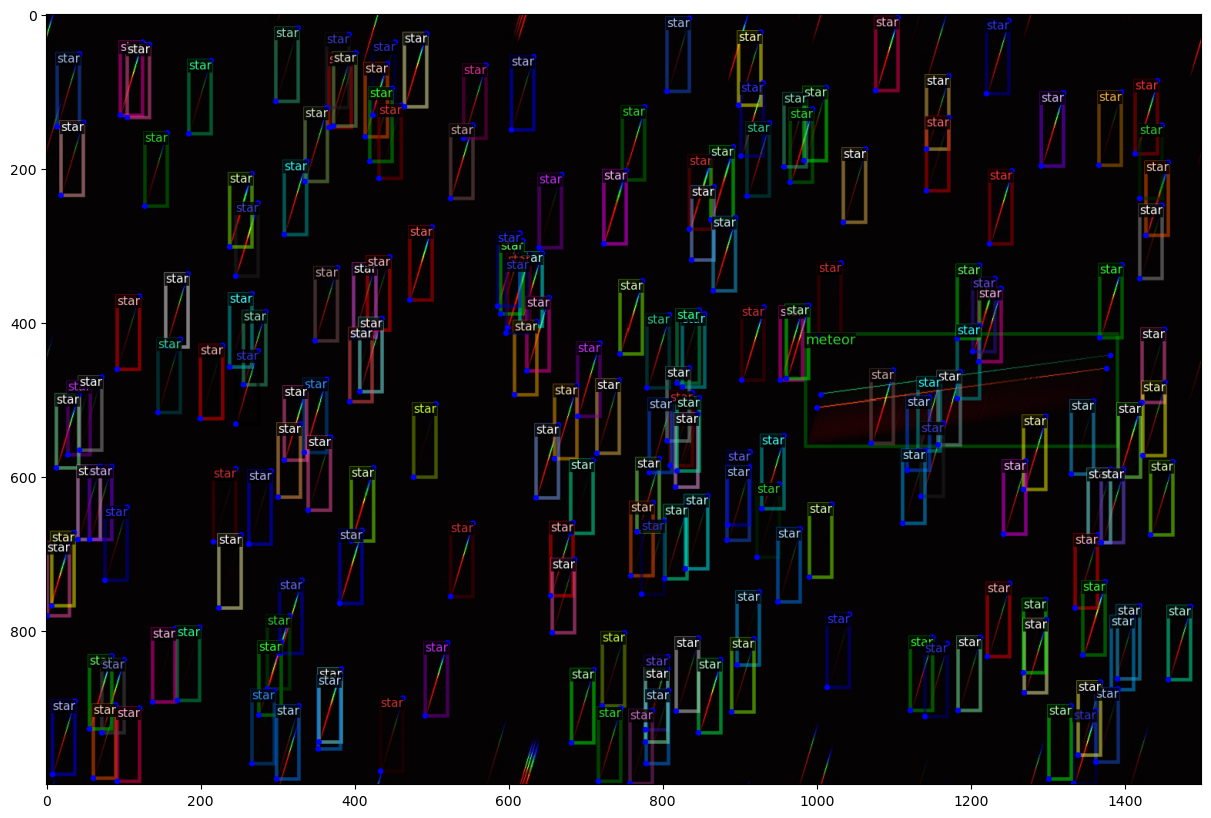

In [6]:

dataset_dicts = DatasetCatalog.get('fake_meteors')
metadata = MetadataCatalog.get('fake_meteors')

for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])


## Train

Using `R50-FPN 3x` model in `COCO Person Keypoint Detection Baselines with Keypoint R-CNN` 

In [36]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg

MetadataCatalog.get("fake_meteors").keypoint_names = ['0', '1', '2', '3']
MetadataCatalog.get("fake_meteors").keypoint_flip_map = []
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fake_meteors",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 7000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/10 17:28:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/10 17:28:33 d2.data.datasets.coco]: Loaded 121 images in COCO format from ./dataset/labels.json
[02/10 17:28:33 d2.data.build]: Removed 0 images with no usable annotations. 121 images left.
[02/10 17:28:33 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[02/10 17:28:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/10 17:28:33 d2.data.build]: Using training sampler TrainingSampler
[02/10 17:28:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/10 17:28:33 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[02/10 17:28:33 d2.data.common]: Serialized dataset takes 2.41 MiB
[02/10 17:28:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[02/10 17:28:33 d2.engine.hooks]: Lo

/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/10 17:28:41 d2.utils.events]:  eta: 0:23:11  iter: 3019  total_loss: 7.31  loss_cls: 0.2058  loss_box_reg: 0.2583  loss_keypoint: 6.528  loss_rpn_cls: 0.06131  loss_rpn_loc: 0.144  time: 0.3474  data_time: 0.1534  lr: 0.0001  max_mem: 5286M
[02/10 17:28:46 d2.utils.events]:  eta: 0:21:10  iter: 3039  total_loss: 7.283  loss_cls: 0.2192  loss_box_reg: 0.2638  loss_keypoint: 6.625  loss_rpn_cls: 0.06277  loss_rpn_loc: 0.148  time: 0.3121  data_time: 0.0889  lr: 0.0001  max_mem: 5286M
[02/10 17:28:52 d2.utils.events]:  eta: 0:19:10  iter: 3059  total_loss: 7.36  loss_cls: 0.2173  loss_box_reg: 0.2475  loss_keypoint: 6.473  loss_rpn_cls: 0.06467  loss_rpn_loc: 0.1561  time: 0.2975  data_time: 0.0758  lr: 0.0001  max_mem: 5286M
[02/10 17:28:57 d2.utils.events]:  eta: 0:18:33  iter: 3079  total_loss: 7.367  loss_cls: 0.2436  loss_box_reg: 0.2848  loss_keypoint: 6.546  loss_rpn_cls: 0.05622  loss_rpn_loc: 0.1649  time: 0.2898  data_time: 0.0779  lr: 0.0001  max_mem: 5286M
[02/10 17:29:02 

[02/10 17:31:38 d2.utils.events]:  eta: 0:14:53  iter: 3679  total_loss: 7.273  loss_cls: 0.1974  loss_box_reg: 0.2485  loss_keypoint: 6.606  loss_rpn_cls: 0.07327  loss_rpn_loc: 0.1418  time: 0.2697  data_time: 0.0742  lr: 0.0001  max_mem: 5286M
[02/10 17:31:43 d2.utils.events]:  eta: 0:14:46  iter: 3699  total_loss: 7.067  loss_cls: 0.2164  loss_box_reg: 0.2054  loss_keypoint: 6.509  loss_rpn_cls: 0.05296  loss_rpn_loc: 0.1281  time: 0.2696  data_time: 0.0761  lr: 0.0001  max_mem: 5286M
[02/10 17:31:49 d2.utils.events]:  eta: 0:14:41  iter: 3719  total_loss: 7.171  loss_cls: 0.1701  loss_box_reg: 0.2093  loss_keypoint: 6.537  loss_rpn_cls: 0.05353  loss_rpn_loc: 0.1225  time: 0.2696  data_time: 0.0758  lr: 0.0001  max_mem: 5286M
[02/10 17:31:54 d2.utils.events]:  eta: 0:14:35  iter: 3739  total_loss: 7.226  loss_cls: 0.1813  loss_box_reg: 0.2531  loss_keypoint: 6.619  loss_rpn_cls: 0.06553  loss_rpn_loc: 0.1496  time: 0.2694  data_time: 0.0728  lr: 0.0001  max_mem: 5286M
[02/10 17:31

[02/10 17:34:35 d2.utils.events]:  eta: 0:11:51  iter: 4339  total_loss: 7.044  loss_cls: 0.1759  loss_box_reg: 0.199  loss_keypoint: 6.465  loss_rpn_cls: 0.05396  loss_rpn_loc: 0.1295  time: 0.2685  data_time: 0.0759  lr: 0.0001  max_mem: 5286M
[02/10 17:34:40 d2.utils.events]:  eta: 0:11:46  iter: 4359  total_loss: 7.21  loss_cls: 0.16  loss_box_reg: 0.2245  loss_keypoint: 6.651  loss_rpn_cls: 0.05276  loss_rpn_loc: 0.1476  time: 0.2684  data_time: 0.0759  lr: 0.0001  max_mem: 5286M
[02/10 17:34:45 d2.utils.events]:  eta: 0:11:40  iter: 4379  total_loss: 6.99  loss_cls: 0.1501  loss_box_reg: 0.2178  loss_keypoint: 6.374  loss_rpn_cls: 0.05426  loss_rpn_loc: 0.1224  time: 0.2684  data_time: 0.0725  lr: 0.0001  max_mem: 5286M
[02/10 17:34:51 d2.utils.events]:  eta: 0:11:35  iter: 4399  total_loss: 7.027  loss_cls: 0.1827  loss_box_reg: 0.2343  loss_keypoint: 6.459  loss_rpn_cls: 0.0479  loss_rpn_loc: 0.1304  time: 0.2683  data_time: 0.0695  lr: 0.0001  max_mem: 5286M
[02/10 17:34:56 d2

[02/10 17:37:32 d2.utils.events]:  eta: 0:08:55  iter: 4999  total_loss: 6.968  loss_cls: 0.1248  loss_box_reg: 0.1878  loss_keypoint: 6.426  loss_rpn_cls: 0.05298  loss_rpn_loc: 0.1189  time: 0.2680  data_time: 0.0725  lr: 0.0001  max_mem: 5286M
[02/10 17:37:37 d2.utils.events]:  eta: 0:08:49  iter: 5019  total_loss: 6.833  loss_cls: 0.1217  loss_box_reg: 0.1837  loss_keypoint: 6.336  loss_rpn_cls: 0.05468  loss_rpn_loc: 0.1264  time: 0.2679  data_time: 0.0625  lr: 0.0001  max_mem: 5286M
[02/10 17:37:43 d2.utils.events]:  eta: 0:08:44  iter: 5039  total_loss: 7.3  loss_cls: 0.1709  loss_box_reg: 0.2339  loss_keypoint: 6.739  loss_rpn_cls: 0.05752  loss_rpn_loc: 0.1341  time: 0.2678  data_time: 0.0667  lr: 0.0001  max_mem: 5286M
[02/10 17:37:48 d2.utils.events]:  eta: 0:08:39  iter: 5059  total_loss: 6.78  loss_cls: 0.1321  loss_box_reg: 0.1692  loss_keypoint: 6.27  loss_rpn_cls: 0.04542  loss_rpn_loc: 0.1087  time: 0.2678  data_time: 0.0803  lr: 0.0001  max_mem: 5286M
[02/10 17:37:53 

[02/10 17:40:29 d2.utils.events]:  eta: 0:05:57  iter: 5659  total_loss: 6.89  loss_cls: 0.1551  loss_box_reg: 0.1849  loss_keypoint: 6.394  loss_rpn_cls: 0.04954  loss_rpn_loc: 0.1408  time: 0.2677  data_time: 0.0797  lr: 0.0001  max_mem: 5286M
[02/10 17:40:34 d2.utils.events]:  eta: 0:05:52  iter: 5679  total_loss: 7.054  loss_cls: 0.1636  loss_box_reg: 0.2201  loss_keypoint: 6.493  loss_rpn_cls: 0.04915  loss_rpn_loc: 0.1425  time: 0.2677  data_time: 0.0777  lr: 0.0001  max_mem: 5286M
[02/10 17:40:40 d2.utils.events]:  eta: 0:05:47  iter: 5699  total_loss: 6.895  loss_cls: 0.1285  loss_box_reg: 0.1944  loss_keypoint: 6.395  loss_rpn_cls: 0.0515  loss_rpn_loc: 0.125  time: 0.2677  data_time: 0.0703  lr: 0.0001  max_mem: 5286M
[02/10 17:40:45 d2.utils.events]:  eta: 0:05:41  iter: 5719  total_loss: 7.127  loss_cls: 0.1508  loss_box_reg: 0.1864  loss_keypoint: 6.574  loss_rpn_cls: 0.05215  loss_rpn_loc: 0.1298  time: 0.2677  data_time: 0.0690  lr: 0.0001  max_mem: 5286M
[02/10 17:40:50

[02/10 17:43:26 d2.utils.events]:  eta: 0:03:01  iter: 6319  total_loss: 6.9  loss_cls: 0.1448  loss_box_reg: 0.1704  loss_keypoint: 6.445  loss_rpn_cls: 0.05137  loss_rpn_loc: 0.1258  time: 0.2676  data_time: 0.0699  lr: 0.0001  max_mem: 5286M
[02/10 17:43:31 d2.utils.events]:  eta: 0:02:56  iter: 6339  total_loss: 6.943  loss_cls: 0.1434  loss_box_reg: 0.183  loss_keypoint: 6.466  loss_rpn_cls: 0.0528  loss_rpn_loc: 0.1581  time: 0.2676  data_time: 0.0756  lr: 0.0001  max_mem: 5286M
[02/10 17:43:37 d2.utils.events]:  eta: 0:02:50  iter: 6359  total_loss: 6.826  loss_cls: 0.1347  loss_box_reg: 0.1873  loss_keypoint: 6.398  loss_rpn_cls: 0.03976  loss_rpn_loc: 0.1055  time: 0.2676  data_time: 0.0742  lr: 0.0001  max_mem: 5286M
[02/10 17:43:42 d2.utils.events]:  eta: 0:02:45  iter: 6379  total_loss: 7.036  loss_cls: 0.1362  loss_box_reg: 0.1764  loss_keypoint: 6.43  loss_rpn_cls: 0.04996  loss_rpn_loc: 0.1151  time: 0.2676  data_time: 0.0714  lr: 0.0001  max_mem: 5286M
[02/10 17:43:47 d

[02/10 17:46:23 d2.utils.events]:  eta: 0:00:05  iter: 6979  total_loss: 6.595  loss_cls: 0.1228  loss_box_reg: 0.1855  loss_keypoint: 6.093  loss_rpn_cls: 0.04763  loss_rpn_loc: 0.1096  time: 0.2675  data_time: 0.0749  lr: 0.0001  max_mem: 5286M
[02/10 17:46:29 d2.utils.events]:  eta: 0:00:00  iter: 6999  total_loss: 7.116  loss_cls: 0.1416  loss_box_reg: 0.202  loss_keypoint: 6.468  loss_rpn_cls: 0.04366  loss_rpn_loc: 0.1354  time: 0.2675  data_time: 0.0750  lr: 0.0001  max_mem: 5286M
[02/10 17:46:29 d2.engine.hooks]: Overall training speed: 3998 iterations in 0:17:49 (0.2675 s / it)
[02/10 17:46:29 d2.engine.hooks]: Total training time: 0:17:54 (0:00:04 on hooks)


[02/10 17:49:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


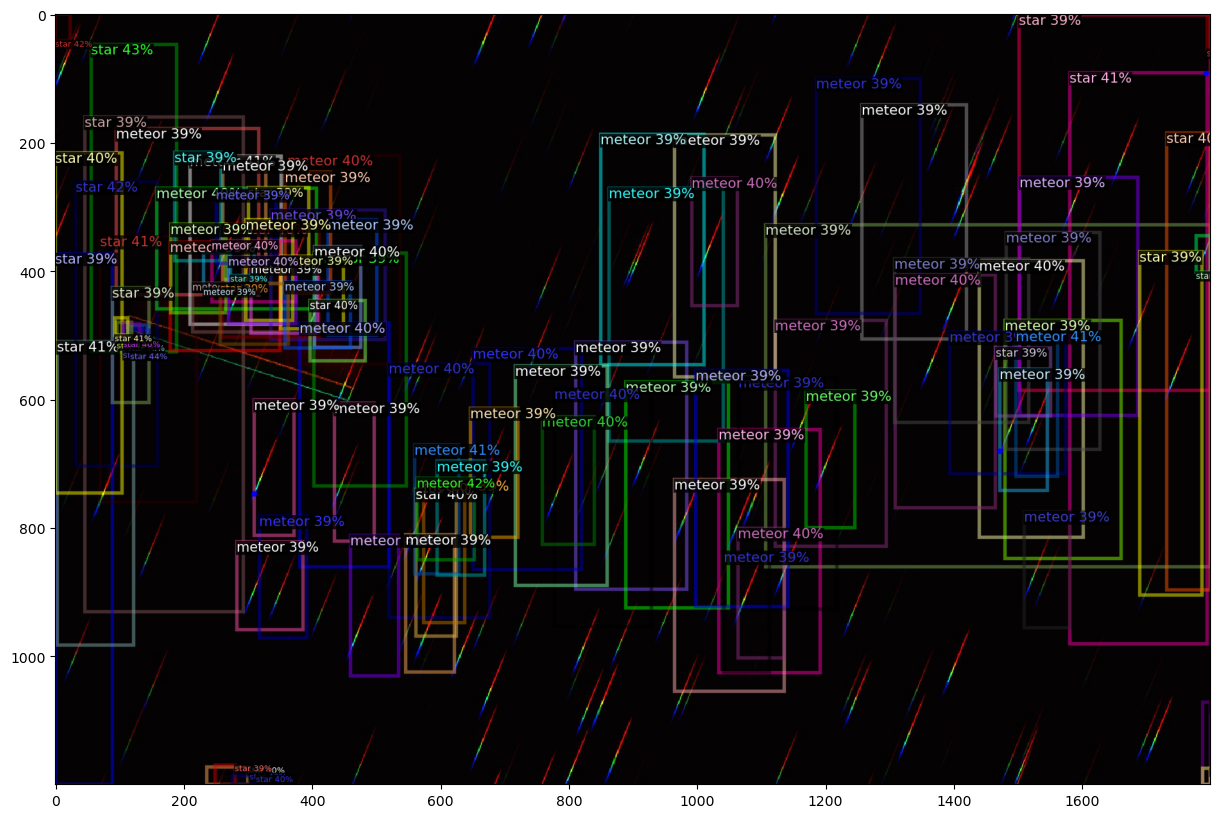

In [37]:
from detectron2.engine import DefaultPredictor

for d in random.sample(dataset_dicts, 1):    
    im = plt.imread(d["file_name"])
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])

# Evaluation

See how it works in our validation dataset (TODO) and the real image

IndexError: list index out of range

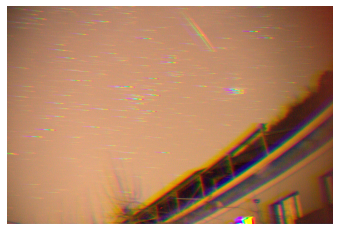

In [5]:
import rawpy

path = '../01/IMG_0241.CR2'
with rawpy.imread(path) as raw:
#     rgb = raw.postprocess(output_bps=16)
    rgb_show = raw.postprocess(output_bps=8)
im = cv2.resize(img, dsize=(1000, 1500), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=[15, 10])
plt.imshow(rgb_show, cmap=plt.cm.gray)
outputs = predictor(rgb_show)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [10]:
metadata

namespace(name='fake_meteors',
          json_file='./dataset/labels.json',
          image_root='./dataset/',
          evaluator_type='coco',
          thing_classes=['meteor', 'star'],
          thing_dataset_id_to_contiguous_id={1: 0, 2: 1},
          keypoint_names=['meteor', 'star'],
          keypoint_flip_map=[])